In [155]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("raghadalharbi/all-products-available-on-sephora-website")

print("Path to dataset files:", path)

Path to dataset files: /Users/mac/.cache/kagglehub/datasets/raghadalharbi/all-products-available-on-sephora-website/versions/1


In [156]:
# 다운로드된 파일 목록 출력
files = os.listdir(path)
print("Downloaded files:", files)

Downloaded files: ['sephora_website_dataset.csv']


In [157]:
# CSV 파일 경로
csv_file = os.path.join(path, files[0])  # 실제 파일명을 입력하세요

# CSV 파일 읽기
df = pd.read_csv(csv_file)

# 데이터 출력
display(df.head())

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,...,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer
0,2218774,Acqua Di Parma,Fragrance,Blu Mediterraneo MINIATURE Set,5 x 0.16oz/5mL,4.0,4,3002,66.0,75.0,...,True,online only,no options,This enchanting set comes in a specially handc...,Suggested Usage:-Fragrance is intensified by t...,Arancia di Capri Eau de Toilette: Alcohol Dena...,1,0,0,0
1,2044816,Acqua Di Parma,Cologne,Colonia,0.7 oz/ 20 mL,4.5,76,2700,66.0,66.0,...,True,online only,- 0.7 oz/ 20 mL Spray - 1.7 oz/ 50 mL Eau d...,An elegant timeless scent filled with a fresh-...,no instructions,unknown,1,0,0,0
2,1417567,Acqua Di Parma,Perfume,Arancia di Capri,5 oz/ 148 mL,4.5,26,2600,180.0,180.0,...,True,online only,- 1oz/30mL Eau de Toilette - 2.5 oz/ 74 mL E...,Fragrance Family: Fresh Scent Type: Fresh Citr...,no instructions,Alcohol Denat.- Water- Fragrance- Limonene- Li...,1,0,0,0
3,1417617,Acqua Di Parma,Perfume,Mirto di Panarea,2.5 oz/ 74 mL,4.5,23,2900,120.0,120.0,...,True,online only,- 1 oz/ 30 mL Eau de Toilette Spray - 2.5 oz/...,Panarea near Sicily is an an island suspended ...,no instructions,unknown,1,0,0,0
4,2218766,Acqua Di Parma,Fragrance,Colonia Miniature Set,5 x 0.16oz/5mL,3.5,2,943,72.0,80.0,...,True,online only,no options,The Colonia Miniature Set comes in an iconic A...,Suggested Usage:-Fragrance is intensified by t...,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,1,0,0,0


In [158]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder

# import shap

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# 클러스터링 기법

In [159]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [160]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 1000개의 샘플 데이터 생성
n_samples = 1000

# 방문 횟수
visits = np.random.poisson(5, n_samples)

# 체류 시간 (분)
time_spent = np.random.gamma(2, 10, n_samples)

# 장바구니 추가 비율
cart_add_rate = np.random.beta(2, 5, n_samples)

# 구매 전환율
conversion_rate = np.random.beta(1.5, 8, n_samples)

# 평균 구매 금액
avg_purchase = np.random.lognormal(10, 1, n_samples)

# 회원 가입 후 경과일
days_since_signup = np.random.gamma(5, 30, n_samples)

# 데이터프레임 생성
data = pd.DataFrame({
    'visits': visits,
    'time_spent': time_spent,
    'cart_add_rate': cart_add_rate,
    'conversion_rate': conversion_rate,
    'avg_purchase': avg_purchase,
    'days_since_signup': days_since_signup
})

In [161]:
data.head()

,visits,time_spent,cart_add_rate,conversion_rate,avg_purchase,days_since_signup
0,5,17.157155,0.156398,0.113986,9899.674055,136.711474
1,4,13.379257,0.658236,0.068572,12239.066864,107.382389
2,4,1.787117,0.645612,0.044786,20498.837791,157.971130
3,5,61.514405,0.429665,0.183890,80273.254017,109.941143
4,5,17.120861,0.443888,0.126339,10962.871058,124.761975


In [162]:
print(data.isnull().sum())

visits               0
time_spent           0
cart_add_rate        0
conversion_rate      0
avg_purchase         0
days_since_signup    0
dtype: int64


In [163]:
# 이상치 확인: IQR
for col in data.columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()
    print(f"{col} 이상치 수: {outliers}")

visits 이상치 수: 12
time_spent 이상치 수: 32
cart_add_rate 이상치 수: 6
conversion_rate 이상치 수: 25
avg_purchase 이상치 수: 59
days_since_signup 이상치 수: 17


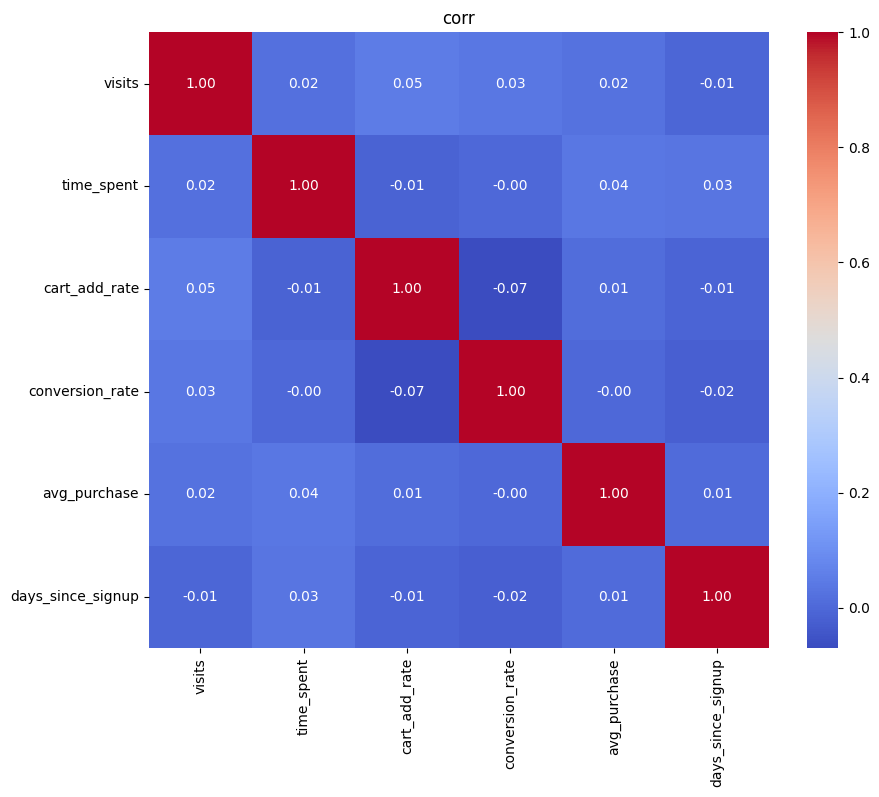

In [164]:
# 변수 간 상관관계 확인
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('corr')
plt.show()

In [165]:
# 표준화
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, columns=data.columns)

In [166]:
# 최적의 클러스터 수 찾기 (Elbow Method, Silhouette Score)
max_clusters = 10
inertias = []
silhouette_scores = []

for k in range(2, max_clusters + 1):
    # K-means 모델 학습
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    kmeans.fit(scaled_data)

    # 관성(inertia) 저장 - 클러스터 내 거리 제곱합 (낮을수록 좋음)
    inertias.append(kmeans.inertia_)

    # 실루엣 점수 계산 (높을수록 좋음, -1~1 사이 값)
    score = silhouette_score(scaled_data, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"K={k}, 실루엣 점수={score:.3f}")

K=2, 실루엣 점수=0.138
K=3, 실루엣 점수=0.135
K=4, 실루엣 점수=0.145
K=5, 실루엣 점수=0.150
K=6, 실루엣 점수=0.160
K=7, 실루엣 점수=0.162
K=8, 실루엣 점수=0.141
K=9, 실루엣 점수=0.144
K=10, 실루엣 점수=0.136


Text(0, 0.5, 'Inertia')

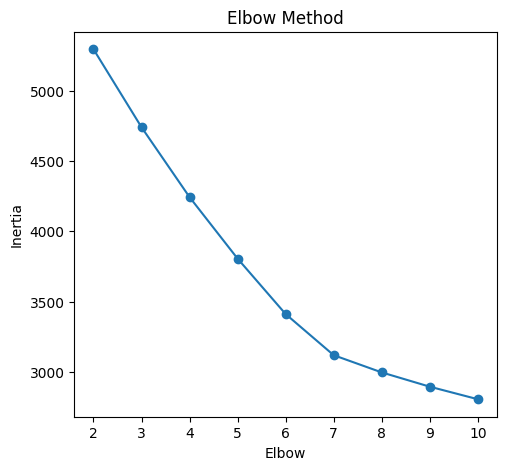

In [167]:
# Elbow Method 시각화 (관성이 급격히 감소하다가 완만해지는 지점이 최적 클러스터 수)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Elbow')
plt.ylabel('Inertia')

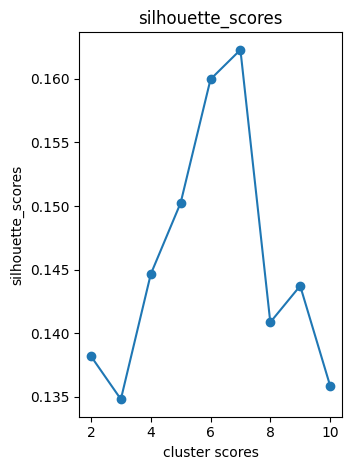

In [168]:
# 실루엣 점수 시각화 (실루엣 점수가 가장 높은 지점이 최적 클러스터 수)
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('silhouette_scores')
plt.xlabel('cluster scores')
plt.ylabel('silhouette_scores')
plt.tight_layout()
plt.show()

In [169]:
# 최적의 클러스터 수 (실루엣 점수 기준)
optimal_k_kmeans = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"최적의 클러스터 수 (K-means): {optimal_k_kmeans}")

최적의 클러스터 수 (K-means): 7


In [170]:
# K-means 모델 학습
kmeans_final = KMeans(n_clusters=optimal_k_kmeans, random_state=RANDOM_SEED, n_init=10)
kmeans_final.fit(scaled_data)
kmeans_labels = kmeans_final.labels_

In [171]:
# 클러스터 결과를 원본 데이터에 추가
data_with_kmeans = data.copy()
data_with_kmeans['kmeans_cluster'] = kmeans_labels

In [172]:
data_with_kmeans.head()

,visits,time_spent,cart_add_rate,conversion_rate,avg_purchase,days_since_signup,kmeans_cluster
0,5,17.157155,0.156398,0.113986,9899.674055,136.711474,3
1,4,13.379257,0.658236,0.068572,12239.066864,107.382389,2
2,4,1.787117,0.645612,0.044786,20498.837791,157.971130,2
3,5,61.514405,0.429665,0.183890,80273.254017,109.941143,4
4,5,17.120861,0.443888,0.126339,10962.871058,124.761975,2


In [173]:
kmeans_stats = data_with_kmeans.groupby('kmeans_cluster').agg({
    'visits': ['mean', 'median', 'std', 'min', 'max'],
    'time_spent': ['mean', 'median', 'std', 'min', 'max'],
    'cart_add_rate': ['mean', 'median', 'std', 'min', 'max'],
    'conversion_rate': ['mean', 'median', 'std', 'min', 'max'],
    'avg_purchase': ['mean', 'median', 'std', 'min', 'max'],
    'days_since_signup': ['mean', 'median', 'std', 'min', 'max']
})

kmeans_stats.head()

visits                          time_spent             \
                    mean median       std min max       mean     median   
kmeans_cluster                                                            
0               4.520000    4.5  1.838149   0  11  18.527515  16.383250   
1               7.708571    7.0  1.478072   6  11  15.476395  13.892013   
2               5.440994    5.0  1.819494   2  11  16.299695  16.016129   
3               3.198347    3.0  1.324019   0   5  15.771258  14.347198   
4               4.772277    5.0  2.004401   1  12  49.315462  46.512929   

                                                 ...  avg_purchase  \
                      std        min        max  ...          mean   
kmeans_cluster                                   ...                 
0               11.183416   1.182788  64.548618  ...  27141.536039   
1                9.250008   0.907431  39.734908  ...  29825.278610   
2                9.497124   0.805928  43.299636  ...  31365.632528   
3                8.891399   0.746018  38.073550  ...  26731.535210   
4               13.022094  29.289230  93.741866  ...  40264.287819   

                                                                        \
                      median           std          min            max   
kmeans_cluster                                                           
0               21363.797697  22519.590596   901.784801  101347.703821   
1               25175.666532  22330.178450  1175.412851  100431.484228   
2               24174.817624  24179.300504  2514.524657  125259.987755   
3               19198.805557  22051.263764  1730.082685   93353.003281   
4               32887.930373  30771.315952  3361.317518  174753.658196   

               days_since_signup                                     \
                            mean      median        std         min   
kmeans_cluster                                                        
0                     260.478063  251.488092  52.341578  185.872531   
1                     139.094049  133.080044  50.651677   42.552499   
2                     130.022847  124.761975  49.088551   24.096728   
3                     119.227569  121.183398  41.302558   22.905177   
4                     142.414532  136.129586  59.093908   41.952170   

                            
                       max  
kmeans_cluster              
0               414.371912  
1               280.129979  
2               298.318996  
3               214.424897  
4               338.924502  

[5 rows x 30 columns]

ValueError: Length of tuple vectors must match length of `data` when both are used, but `data` has length 1000 and the vector passed to `y` has length 2.

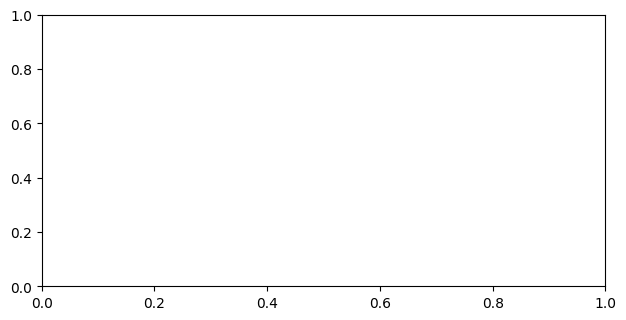

In [174]:
# 클러스터별 데이터 분포 시각화 (violin plot)
plt.figure(figsize=(16, 12))
for i, var in enumerate(kmeans_stats):
    plt.subplot(3, 2, i+1)
    sns.violinplot(x='kmeans_cluster', y=var, data=data_with_kmeans)
    plt.title(f'cluster {var} (Violin Plot)')
    plt.xlabel('K-means cluster')
    plt.ylabel(var)
plt.tight_layout()
plt.show()

# 상품 가격 예측 모델
- 데이터 출처: https://www.kaggle.com/datasets/raghadalharbi/all-products-available-on-sephora-website/data

In [ ]:
df = pd.read_csv('/content/sample_data/sephora_website_dataset.csv')

In [ ]:
df.describe()

,id,rating,number_of_reviews,love,price,value_price,online_only,exclusive,limited_edition,limited_time_offer
count,9.168000e+03,9168.000000,9168.000000,9.168000e+03,9168.000000,9168.00000,9168.000000,9168.000000,9168.000000,9168.000000
mean,1.962952e+06,3.990020,282.139180,1.627859e+04,50.063237,51.82359,0.234839,0.264725,0.091841,0.000327
std,3.859714e+05,1.007707,890.642028,4.260651e+04,47.164989,49.45902,0.423921,0.441211,0.288817,0.018087
min,5.000000e+01,0.000000,0.000000,0.000000e+00,2.000000,2.00000,0.000000,0.000000,0.000000,0.000000
25%,1.819453e+06,4.000000,10.000000,1.600000e+03,24.000000,25.00000,0.000000,0.000000,0.000000,0.000000
50%,2.072354e+06,4.000000,46.000000,4.800000e+03,35.000000,35.00000,0.000000,0.000000,0.000000,0.000000
75%,2.230591e+06,4.500000,210.000000,1.380000e+04,59.000000,60.00000,0.000000,1.000000,0.000000,0.000000
max,2.359685e+06,5.000000,19000.000000,1.300000e+06,549.000000,549.00000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9168 entries, 0 to 9167
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      9168 non-null   int64  
 1   brand                   9168 non-null   object 
 2   category                9168 non-null   object 
 3   name                    9168 non-null   object 
 4   size                    9168 non-null   object 
 5   rating                  9168 non-null   float64
 6   number_of_reviews       9168 non-null   int64  
 7   love                    9168 non-null   int64  
 8   price                   9168 non-null   float64
 9   value_price             9168 non-null   float64
 10  URL                     9168 non-null   object 
 11  MarketingFlags          9168 non-null   bool   
 12  MarketingFlags_content  9168 non-null   object 
 13  options                 9168 non-null   object 
 14  details                 9168 non-null   

In [ ]:
#브랜드별 상품 수
brand_products = df.groupby('brand')['name'].count().reset_index(name='prod_cnt').sort_values(['prod_cnt'], ascending=False)
brand_products

,brand,prod_cnt
232,SEPHORA COLLECTION,496
38,CLINIQUE,234
322,tarte,170
262,TOM FORD,161
69,Dior,145
...,...,...
166,MDSolarSciences,1
233,SHHHOWERCAP,1
274,Too Cool For School,1
273,TokyoMilk,1


In [ ]:
#가장 리뷰가 많은 카테고리
brand_reviews = df.groupby('category')['number_of_reviews'].count().reset_index(name='review_count').sort_values(['review_count'], ascending=False)
brand_reviews.head(10)

,category,review_count
119,Perfume,665
116,Moisturizers,451
58,Face Serums,384
140,Value & Gift Sets,378
62,Face Wash & Cleansers,247
55,Face Masks,230
122,Rollerballs & Travel Size,228
85,Hair Styling Products,224
47,Eye Palettes,202
45,Eye Creams & Treatments,191


In [ ]:
#가장 평균 평점이 높은 브랜드는?
# 각 카테고리별 평균 평점이 높은 순서로 정렬
brand_reviews = df.groupby('brand')['rating'].mean().reset_index(name='average_rating').sort_values(by='average_rating', ascending=False)

# 상위 10개 출력
brand_reviews.head(10)


,brand,average_rating
180,Montblanc,5.000000
5,Aether Beauty,5.000000
98,Four Sigmatic,5.000000
93,Fable & Mane,5.000000
104,Golde,4.875000
223,RODIN olio lusso,4.812500
268,The Art of Shaving,4.700000
236,SOBEL SKIN Rx,4.687500
210,Paco Rabanne,4.687500
281,Valentino,4.666667


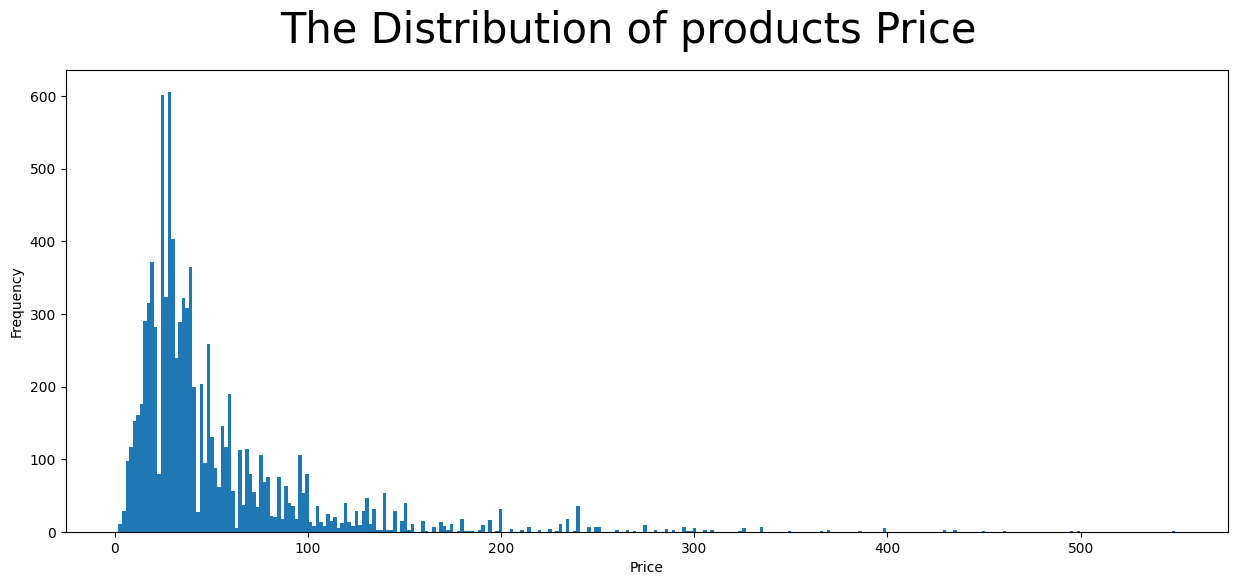

In [ ]:
#가격 분포
fig, ax = plt.subplots( figsize=(15, 6))
ax.hist(df['price'], bins = 300)

ax.set_xlabel('Price')
ax.set_ylabel('Frequency')
fig.suptitle('The Distribution of products Price', fontsize = 30)

ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.show()

In [176]:
df['discount_price'] = df['price'] - df['value_price']

# 할인 가격 컬럼을 로그 변환 (로그(0) 방지를 위해 1 추가)
df['log_discount_price'] = np.log(df['discount_price'])

# 변환된 데이터 확인
df[['discount_price', 'log_discount_price']].head()
df


,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,...,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer,discount_price,log_discount_price
0,2218774,Acqua Di Parma,Fragrance,Blu Mediterraneo MINIATURE Set,5 x 0.16oz/5mL,4.0,4,3002,66.0,75.0,...,no options,This enchanting set comes in a specially handc...,Suggested Usage:-Fragrance is intensified by t...,Arancia di Capri Eau de Toilette: Alcohol Dena...,1,0,0,0,-9.0,NaN
1,2044816,Acqua Di Parma,Cologne,Colonia,0.7 oz/ 20 mL,4.5,76,2700,66.0,66.0,...,- 0.7 oz/ 20 mL Spray - 1.7 oz/ 50 mL Eau d...,An elegant timeless scent filled with a fresh-...,no instructions,unknown,1,0,0,0,0.0,-inf
2,1417567,Acqua Di Parma,Perfume,Arancia di Capri,5 oz/ 148 mL,4.5,26,2600,180.0,180.0,...,- 1oz/30mL Eau de Toilette - 2.5 oz/ 74 mL E...,Fragrance Family: Fresh Scent Type: Fresh Citr...,no instructions,Alcohol Denat.- Water- Fragrance- Limonene- Li...,1,0,0,0,0.0,-inf
3,1417617,Acqua Di Parma,Perfume,Mirto di Panarea,2.5 oz/ 74 mL,4.5,23,2900,120.0,120.0,...,- 1 oz/ 30 mL Eau de Toilette Spray - 2.5 oz/...,Panarea near Sicily is an an island suspended ...,no instructions,unknown,1,0,0,0,0.0,-inf
4,2218766,Acqua Di Parma,Fragrance,Colonia Miniature Set,5 x 0.16oz/5mL,3.5,2,943,72.0,80.0,...,no options,The Colonia Miniature Set comes in an iconic A...,Suggested Usage:-Fragrance is intensified by t...,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,1,0,0,0,-8.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9163,2208502,SEPHORA COLLECTION,Face Masks,The Rose Gold Mask,no size,2.0,15,6200,6.0,6.0,...,no options,What it is: A limited-edition- nurturing and h...,Suggested Usage:-Unfold the mask.-Apply the ma...,-Rose Quartz Extract: Hydrates dry skin. Aqua...,0,1,1,0,0.0,-inf
9164,2298909,SEPHORA COLLECTION,Lip Sets,Give Me Some Sugar Colorful Gloss Balm Set,3 x 0.32 oz/ 9 g,0.0,0,266,15.0,27.0,...,no options,What it is: A set of three bestselling Colorfu...,Suggested Usage:-Apply directly to lips using ...,Colorful Gloss Balm Wanderlust: Hydrogenated P...,0,1,0,0,-12.0,NaN
9165,2236750,SEPHORA COLLECTION,Tinted Moisturizer,Weekend Warrior Tone Up Cream,0.946 oz/ 28 mL,0.0,0,445,16.0,16.0,...,no options,What it is: A weightless complexion booster- i...,Suggested Usage:-Use this product as the last ...,Aqua (Water)- Dimethicone- Isohexadecane- Poly...,0,1,0,0,0.0,-inf
9166,50,SEPHORA COLLECTION,no category,Gift Card,no size,5.0,46,0,50.0,50.0,...,no options,What it is:- Available in denominations of $10...,no instructions,unknown,0,0,0,0,0.0,-inf


In [ ]:
df['rating'].value_counts()

,count
rating,
4.5,3527
4.0,2853
3.5,1051
5.0,872
0.0,398
3.0,308
2.5,88
2.0,39
1.0,23


In [ ]:
df.select_dtypes('object').columns

Index(['brand', 'category', 'name', 'URL', 'MarketingFlags_content', 'options',
       'details', 'how_to_use', 'ingredients'],
      dtype='object')

In [ ]:
#중복값
df.drop_duplicates(inplace = True)
df.duplicated().sum()

0

<Axes: >

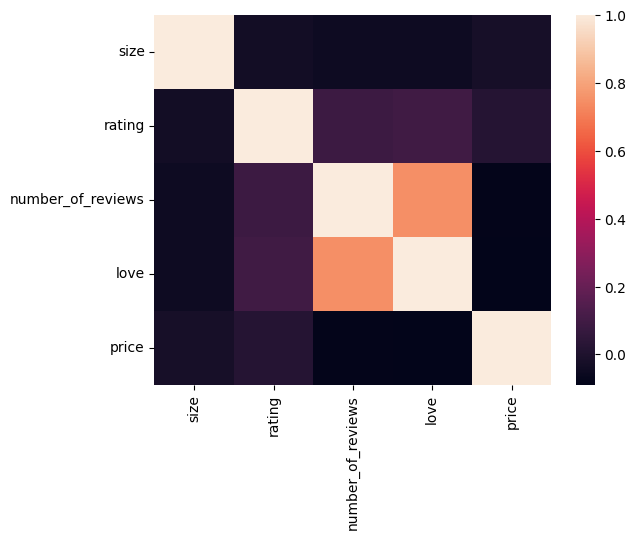

In [ ]:
# 수치형 변수들의 상관관계 계산
numeric_features = ['size',
                   'rating', 'number_of_reviews', 'love', 'price']
correlation_matrix = df[numeric_features].corr()
sns.heatmap(data=correlation_matrix)

In [ ]:
columns_to_drop = ['MarketingFlags_content', 'MarketingFlags', 'URL']
existing_columns = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=existing_columns)
df.columns

Index(['id', 'brand', 'category', 'name', 'size', 'rating',
       'number_of_reviews', 'love', 'price', 'value_price', 'options',
       'details', 'how_to_use', 'ingredients', 'online_only', 'exclusive',
       'limited_edition', 'limited_time_offer', 'brand_avg_price'],
      dtype='object')

In [ ]:
# 피처와 타겟 변수 선택
columns_to_keep = [
    'brand', 'category', 'size', 'number_of_reviews', 'love', 'price', 'value_price',
    'online_only', 'exclusive', 'limited_edition', 'limited_time_offer', 'log_discount_price'
]
target = 'price'

RMSE: 5.0287


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

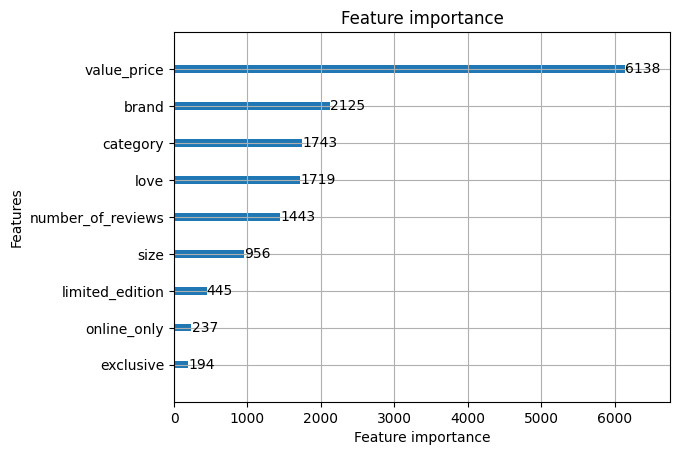

In [ ]:
# 범주형 변수(Label Encoding)
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 데이터셋 분리
X = df.drop(columns=[target])
y = df[target]

# 데이터셋 분리 (학습 80%, 테스트 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# LightGBM 모델 설정
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1
}

# 모델 학습
model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=500)

# 예측
y_pred = model.predict(X_test)

# 성능 평가 (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

# feature importance 확인
lgb.plot_importance(model)

In [ ]:
import plotly.graph_objects as go

# 예측 vs 실제 가격 산점도
fig_scatter = go.Figure()

fig_scatter.add_trace(go.Scatter(
    x=y_test,
    y=y_pred,
    mode='markers',
    name='Predictions',
    marker=dict(
        size=8,
        opacity=0.6,
        color='blue'
    )
))

fig_scatter.add_trace(go.Scatter(
    x=[y_test.min(), y_test.max()],
    y=[y_test.min(), y_test.max()],
    mode='lines',
    name='Perfect Prediction',
    line=dict(color='red', dash='dash')
))

fig_scatter.update_layout(
    title='Actual vs Predicted Prices',
    xaxis_title='Actual Price ($)',
    yaxis_title='Predicted Price ($)',
    height=600
)
fig_scatter.show()

In [ ]:
# 가격 구간별 성능 분석
df_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Absolute_Error': np.abs(y_test - y_pred)
})

df_results['Price_Range'] = pd.qcut(df_results['Actual'], q=4,
                                  labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

price_range_analysis = df_results.groupby('Price_Range').agg({
    'Absolute_Error': ['mean', 'std'],
    'Actual': ['count', 'mean']
}).round(2)

# 가격 구간별 성능 출력
print(price_range_analysis)

            Absolute_Error       Actual        
                      mean   std  count    mean
Price_Range                                    
Low                   0.43  1.61    478   17.10
Medium-Low            0.89  2.83    456   29.02
Medium-High           1.22  3.16    454   44.44
High                  4.10  7.98    446  110.80


In [ ]:
# SHAP
# 첫 번째 예측에 대한 설명
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

# SHAP Interaction Values
shap_interaction_values = explainer.shap_interaction_values(X_test)

# 특성 간 상호작용 시각화
feature_names = X.columns
for i in range(len(feature_names)):
    for j in range(i+1, len(feature_names)):
        shap.dependence_plot(
            (feature_names[i], feature_names[j]),
            shap_interaction_values,
            X_test,
            display_features=X_test
        )

# 모델 성능 상세 분석
print("Mean Absolute Error:", np.mean(np.abs(y_test - y_pred)))
print("Mean Absolute Percentage Error:", np.mean(np.abs((y_test - y_pred) / y_test)) * 100)

KeyboardInterrupt: 